## Text Processing Lab

In [1]:
%load_ext watermark
%watermark -v -p numpy,mlxtend,pandas,polars,omegaconf --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
mlxtend  : 0.23.1
pandas   : 2.2.1
polars   : 0.20.18
omegaconf: 2.3.0

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
from tqdm import tqdm


def process_text(text: list[str]) -> list[str]:
    """
    Process a list of text lines to extract product IDs and categories.

    Parameters
    ----------
    text : list[str]
        A list of strings representing lines of text to process.

    Returns
    -------
    list[str]
        A list of strings, each containing a product ID and its associated category.

    """
    result: list[str] = []
    is_id: bool = False
    string: str = ""
    prod_id: str = ""
    pattern = r"^[A-Z][a-z]+"  # Starts with a capital letter and then lowercase letters

    for line in tqdm(text, desc="Processing Text", unit="line", ncols=100):
        counter: int = 0
        if len(line.split(",")) == 1 and len(re.findall(pattern, line.strip())) == 0:
            is_id = True
            prod_id = line.strip()

        elif len(re.findall(pattern, line.strip())) >= 1:
            string = ""
            is_id = False
            prod_cat: str = line.strip()
            string += prod_cat
            counter += 1

        if not is_id and counter > 0:
            result.append(f"{prod_id}: {string}")

    return result

In [4]:
# fp: str = "./sample.txt"
fp: str = "../../data/categories.txt"

with open(fp, "r", encoding="latin-1") as f:
    texts: list[str] = f.readlines()

In [5]:
result: list[str] = process_text(text=texts)

Processing Text: 100%|██████████████████████████████| 7313587/7313587 [00:12<00:00, 577626.24line/s]


In [6]:
data: pl.DataFrame = (
    pl.DataFrame(result)
    .select(
        pl.col("column_0")
        .str.split_exact(":", 1)
        .struct.rename_fields(["product_id", "product_category"])
    )
    .unnest("column_0")
).with_columns(product_category=pl.col("product_category").str.strip())

# Drop duplicates
data = data.unique(subset=["product_id", "product_category"])
print(f"{data.shape = }")
data.head(10)

data.shape = (4869346, 2)


product_id,product_category
str,str
"""B000EBADY8""","""Industrial & Scientific, Cutting Tools, Industrial Drill Bits, Metalworking & Multipurpose Drill Bits, Step Drill Bits"""
"""B00005TZY6""","""Books, Science & Math, Nature & Ecology, Natural Resources"""
"""B000GIWMIE""","""Music, Rock"""
"""0789002000""","""Books, Parenting & Relationships, Family Relationships, Dysfunctional Relationships"""
"""B00000JAIV""","""Music, Classic Rock"""
"""1740471539""","""Books, Children's Books, Animals, Bugs & Spiders"""
"""0812924975""","""Books, Biographies & Memoirs, Arts & Literature, Authors"""
"""0140377182""","""Books, Teens"""
"""B00004Z4ZR""","""Music, Alternative Rock"""


In [7]:
# data_grpby: pl.DataFrame = data.group_by("product_id").agg(
#     pl.col("product_category").explode()
# )

# OR
data_grpby: pl.DataFrame = data.groupby("product_id").agg(
    pl.col("product_category").map_elements(lambda x: " ".join(x))
)

# OR
# data_grpby: pl.DataFrame = data.group_by("product_id").agg((pl.struct(pl.col("product_category"))))
data_grpby.head()

product_id,product_category
str,str
"""9622017762""","""Books, Politics & Social Sciences, Social Sciences, Specific Demographics, Ethnic Studies Books, Business & Investing, Popular Economics Books, History, Asia, China Books, Business & Investing, Real Estate Books, Professional & Technical, Accounting & Finance, International"""
"""B000QE9AZQ""","""Home & Kitchen, Furniture, Living Room Furniture, Sofas & Couches"""
"""B0001K5ZOU""","""Shoes, Men"""
"""B0000CDOJ3""","""Electronics, Computers & Accessories, Computer Components"""
"""B000924R5I""","""Cell Phones & Accessories, Accessories, Data Cables"""


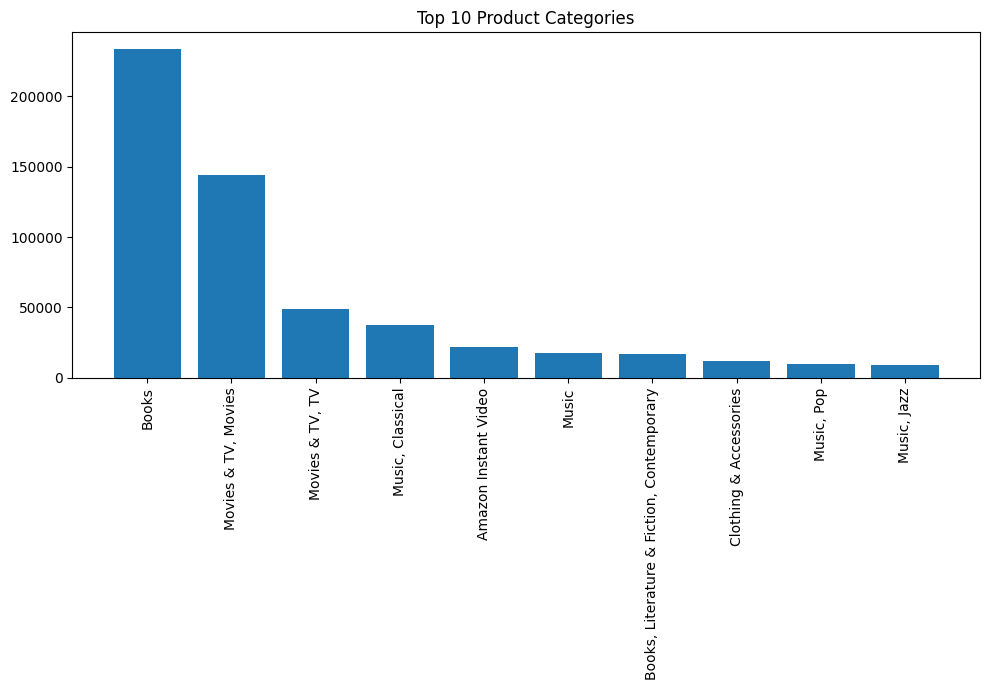

In [8]:
N: int = 10
d: pl.DataFrame = (
    data_grpby.select("product_category").to_series().value_counts(sort=True).head(N)
)
plt.figure(figsize=(10, 7))
plt.bar(d["product_category"], d["count"])
plt.xticks(rotation=90)
plt.title(f"Top {N} Product Categories")
plt.tight_layout()
plt.show()